# DOPP 2019W Exercise 3 - Group 32

### Contributors
- Eszter Katalin Bognar - 11931695
- Luis Kolb - 01622731
- Alexander Leitner - 01525882

### Objectives of the analysis
- What is the most accurate overview of flows of refugees between countries that can be obtained? 
- Are there typical characteristics of refugee origin and destination countries? 
- Are there typical characteristics of large flows of refugees? 
- Can countries that will produce large numbers of refugees be predicted? Can refugee flows be predicted?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

## Load datasets
We started our analysis by loading the necessary data files.

We selected 4 datasets to use:
- OECD International Migration Database data (https://stats.oecd.org/Index.aspx?DataSetCode=MIG)
- Gross Domestic Product per Capita data (https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
- Human Development Index data (http://hdr.undp.org/en/data)
- World Governance Index data (https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators)

Each dataset were loaded and formatted including:

- reshaping columns (changing rows to columns or columns to rows when necessary),
- getting rid of unwanted columns, 
- renaming columns, 
- setting proper data types,
- setting country-year multiindex to facilitate future data merge.

In [2]:
'''
Load & format OECD International Migration Database data
'''

def load_oecd_data():
    """ 
    Load oecd data file
    Reshape the dataset to have country, destination, year, asylum_seekers columns
    Set hierarchical index (country, year)
    
    Returns
    --------
    oecd: data frame containing oecd data
    """
    #load dataset
    oecd = pd.read_csv('data/oecd_data.csv',na_values=['..'])
    #reshape table
    oecd.set_index(['country','destination', 'year','variable'], inplace=True)
    oecd=oecd.unstack()
    oecd.columns = oecd.columns.droplevel(0)
    #drop unwanted columns
    oecd.reset_index(drop=False, inplace=True)
    #rename columns
    oecd = oecd[['country','destination','year','Inflows of asylum seekers by nationality']]
    oecd = oecd.rename(columns={'Inflows of asylum seekers by nationality': 'asylum_seekers'})
    #set index
    oecd=oecd.set_index(['country', 'year'])
    return oecd

oecd_df=load_oecd_data()
oecd_df.info()
oecd_df.head(20)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131072 entries, (Afghanistan, 2000) to (Zimbabwe, 2017)
Data columns (total 2 columns):
destination       131072 non-null object
asylum_seekers    83187 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.4+ MB


variable         destination  asylum_seekers
country     year                            
Afghanistan 2000   Australia          1326.0
            2001   Australia          2161.0
            2002   Australia            53.0
            2003   Australia            54.0
            2004   Australia           116.0
            2005   Australia            32.0
            2006   Australia            21.0
            2007   Australia            20.0
            2008   Australia            52.0
            2009   Australia           940.0
            2010   Australia          1265.0
            2011   Australia          1720.0
            2012   Australia          3064.0
            2013   Australia           370.0
            2014   Australia           123.0
            2015   Australia           567.0
            2016   Australia          2563.0
            2017   Australia          1478.0
            2000     Austria          4205.0
            2001     Austria         12955.0

In [3]:
'''
Load & format Gross Domestic Product per Capita data
'''

def load_gdp_data():
    """ 
    Load gdp data file
    Reshape the dataset to have country, year, GDP columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    gdp: data frame containing gdp data
    """
    #load dataset
    gdp = pd.read_csv('data/GDPPC_data.csv',na_values=['..'])
    #drop unwanted columns
    gdp.drop(['Indicator Name','Indicator Code','Country Code' ], inplace=True, axis=1)
    #reshape dataframe
    gdp.set_index(['Country Name'], inplace=True)
    gdp=gdp.stack(dropna=False).to_frame()
    gdp.reset_index(drop=False, inplace=True)
    #rename columns
    gdp=gdp.rename(columns={'Country Name': 'country', 'level_1': 'year', 0: 'GDP'})
    #set datatype for year, GDP
    gdp['year']=gdp['year'].astype(int)
    gdp['GDP']=gdp['GDP'].astype(float)
    #only use data from 2000 onwards
    gdp = gdp[gdp.year >= 2000]
    #set index
    gdp=gdp.set_index(['country', 'year'])
    return gdp

gdp_df=load_gdp_data()
gdp_df.info()
gdp_df.tail(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5280 entries, (Aruba, 2000) to (Zimbabwe, 2019)
Data columns (total 1 columns):
GDP    4738 non-null float64
dtypes: float64(1)
memory usage: 59.1+ KB


GDP
country  year             
Zimbabwe 2010   948.331854
         2011  1093.654002
         2012  1304.969802
         2013  1430.000818
         2014  1434.899340
         2015  1445.071062
         2016  1464.583529
         2017  1602.403507
         2018  2146.996385
         2019          NaN

In [4]:
'''
Load & format Human Development Index data
'''

def load_hdi_data():
    """ 
    Load hdi data file
    Reshape the dataset to have country, year, HDI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    hdi = pd.read_csv('data/HDI.csv',na_values=['..'])
    #drop unwanted columns
    hdi.drop(['HDI Rank (2018)'], inplace=True, axis=1)
    #reshape dataframe
    hdi.set_index(['Country'], inplace=True)
    hdi=hdi.stack(dropna=False).to_frame()
    hdi.reset_index(drop=False, inplace=True)
    #rename columns
    hdi=hdi.rename(columns={'Country': 'country', 'level_1': 'year', 0: 'HDI'})
    #set datatype for year
    hdi['year']=hdi['year'].astype(int)
    hdi['HDI']=hdi['HDI'].astype(float)
    #only use data from 2000 onwards
    hdi = hdi[hdi.year >= 2000]
    #set index
    hdi=hdi.set_index(['country', 'year'])
    return hdi

hdi_df=load_hdi_data()
hdi_df.info()
hdi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4028 entries, (Afghanistan, 2000) to (World, 2018)
Data columns (total 1 columns):
HDI    3788 non-null float64
dtypes: float64(1)
memory usage: 45.2+ KB


HDI
country     year       
Afghanistan 2000  0.345
            2001  0.347
            2002  0.378
            2003  0.387
            2004  0.400
            2005  0.410
            2006  0.419
            2007  0.431
            2008  0.436
            2009  0.447

In [5]:
'''
Load & format World Governance Index data

column values:
CC.EST: Control of Corruption: Estimate
GE.EST: Government Effectiveness: Estimate
PV.EST: Political Stability and Absence of Violence/Terrorism: Estimate
RL.EST: Rule of Law: Estimate
RQ.EST: Regulatory Quality: Estimate
VA.EST: Voice and Accountability: Estimate

'''


def load_wgi_data():
    """ 
    Load wgi data file
    Reshape the dataset to have country, year, WGI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    wgi = pd.read_csv('data/WGIData.csv',na_values=['..'])
    #drop unwanted rows
    wgi=wgi[wgi['Indicator Code'].str.contains('EST', regex= True, na=False)]
    #drop unwanted columns
    wgi.drop(['Country Code','Indicator Name'], inplace=True, axis=1)
    #reshape dataframe
    wgi.set_index(['Country Name','Indicator Code'], inplace=True)
    wgi=wgi.stack(dropna=False).to_frame()
    wgi.reset_index(drop=False, inplace=True)
    #rename columns
    wgi=wgi.rename(columns={'Country Name': 'country', 'level_2': 'year', 0: 'variable'})
    wgi.set_index(['country','year','Indicator Code'], inplace=True)
    wgi=wgi.unstack()
    wgi.columns = wgi.columns.droplevel(0)
    wgi.reset_index(drop=False, inplace=True)
    #set datatype for year 
    wgi['year']=wgi['year'].astype(int)
    #only use data from 2000 onwards
    wgi = wgi[wgi.year >= 2000]
    #set index
    wgi=wgi.set_index(['country', 'year'])
    return wgi
wgi_df=load_wgi_data()
wgi_df.info()
wgi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3852 entries, (Afghanistan, 2000) to (Zimbabwe, 2018)
Data columns (total 6 columns):
CC.EST    3730 non-null float64
GE.EST    3720 non-null float64
PV.EST    3734 non-null float64
RL.EST    3769 non-null float64
RQ.EST    3719 non-null float64
VA.EST    3737 non-null float64
dtypes: float64(6)
memory usage: 193.8+ KB


Indicator Code      CC.EST    GE.EST    PV.EST    RL.EST    RQ.EST    VA.EST
country     year                                                            
Afghanistan 2000 -1.295380 -2.231651 -2.440187 -1.778437 -2.109626 -2.031417
            2002 -1.263366 -1.567973 -2.035389 -1.670823 -1.804449 -1.433421
            2003 -1.351042 -1.082488 -2.197809 -1.553829 -1.430002 -1.177571
            2004 -1.345281 -0.894051 -2.296179 -1.697143 -1.505863 -1.203034
            2005 -1.443609 -1.210829 -2.070934 -1.658668 -1.637369 -1.125430
            2006 -1.432890 -1.430343 -2.221302 -1.863189 -1.667902 -1.110294
            2007 -1.587331 -1.403352 -2.410581 -1.829666 -1.688257 -1.057654
            2008 -1.638287 -1.496089 -2.690477 -1.864380 -1.621583 -1.168902
            2009 -1.534796 -1.483899 -2.712689 -1.847092 -1.674311 -1.375497
            2010 -1.635723 -1.454683 -2.579152 -1.845436 -1.532861 -1.404468

## Country name inconsistency check 
Before data merge we have to check the datasets for inconsistencies. 
We would like to merge on the country-year multiindex.
Year is consistent in each data files however we have to search for different usage and typos in county names.
We selected oecd_df as base dataframe so we compare the country names in the oecd_df to the country names in the hdi_df, gdp_df, wgi_df datasets.

In [6]:
def country_check(countries, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    countries: list of countries (source or destination) in oecd_df
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    check: dataframe showing inconsistent country name usage
    """   
    #get country name list series
    hdi_c = hdi_df.index.unique(level=0).to_series()
    gdp_c = gdp_df.index.unique(level=0).to_series()
    wgi_c = wgi_df.index.unique(level=0).to_series()
    
    #create dataframe for the results
    check=pd.DataFrame(columns=['country','hdi','gdp','wgi'])
    #iterate through oecd_df source or destination country names and check presence of country name in other dfs
    for index,row in countries.iterrows():
        check=check.append({'country': row.country,
                            'hdi':row.isin(hdi_c).values[0],
                           'gdp':row.isin(gdp_c).values[0],
                           'wgi':row.isin(wgi_c).values[0]}, ignore_index=True)
        
    #add only problematic country rows to the result df
    check=check.loc[(check['hdi'] == False) | (check['gdp'] == False) | (check['wgi'] == False)]
    return check

oecd_s = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_s_check = country_check(oecd_s,gdp_df, hdi_df, wgi_df)

oecd_d = pd.DataFrame(oecd_df['destination'].unique(),columns={'country'})
oecd_d_check = country_check(oecd_d,gdp_df, hdi_df, wgi_df)

display(oecd_d_check.head(50),oecd_s_check.head(50))
df = pd.concat([oecd_d_check,oecd_s_check])

,country,hdi,gdp,wgi
5,Czech Republic,False,True,True
18,Korea,False,False,False
27,Slovak Republic,False,True,True


,country,hdi,gdp,wgi
11,Bahamas,True,False,False
19,Bermuda,False,True,True
21,Bolivia,False,True,True
32,Cape Verde,False,False,False
37,Chinese Taipei,False,False,False
40,Congo,True,False,False
41,Cook Islands,False,False,True
46,Czech Republic,False,True,True
47,Côte d'Ivoire,True,False,False
48,Democratic People's Republic of Korea,False,False,False


For making the country names consistent, we first tried out the fuzzy search method of the fuzzywuzzy library. 
Due to errors, we finally decided to manually create a dictonary of country names to replace or delete them.

In [7]:
country_dict = {
    'Bahamas, The' :"Bahamas",
    'Bolivia (Plurinational State of)' :"Bolivia",
    'Cabo Verde' :"Cape Verde",
    'Congo, Rep.' :"Congo",
    'Czechia' :"Czech Republic",
    "Cote d'Ivoire" :"Côte d'Ivoire",
    'Congo, Dem. Rep.' :"Democratic Republic of the Congo",
    'Congo (Democratic Republic of the)':"Democratic Republic of the Congo",
    'Egypt, Arab Rep.' :"Egypt",
    'Gambia, The' :"Gambia",
    'Iran (Islamic Republic of)' :"Iran",
    'Iran, Islamic Rep.': "Iran",
    'Korea (Republic of)' :"Korea",
    'Korea, Rep.':"Korea",
    'Kyrgyz Republic' :"Kyrgyzstan",
    "Lao People's Democratic Republic" :"Laos",
    "Lao PDR":"Laos",
    'Micronesia (Federated States of)' :"Micronesia",
    'Micronesia, Fed. Sts.':'Micronesia',
    'Moldova (Republic of)' :"Moldova",
    'Russian Federation' :"Russia",
    'St. Kitts and Nevis' :"Saint Kitts and Nevis",
    'St. Lucia' :"Saint Lucia",
    'St. Vincent and the Grenadines' :"Saint Vincent and the Grenadines",
    'Slovakia' :"Slovak Republic",
    'Syrian Arab Republic' :"Syria",
    'Eswatini' :"Swaziland",
    "Eswatini (Kingdom of)": "Swaziland",
    'Tanzania (United Republic of)' :"Tanzania",
    'Venezuela (Bolivarian Republic of)' :"Venezuela",
    "Venezuela, RB":"Venezuela",
    'Vietnam' :"Viet Nam",
    'Yemen, Rep.' :"Yemen"  
}

country_del = [
    #former countries
    "Former Czechoslovakia",
    "Former USSR",
    "Former Yugoslavia",
    "Serbia and Montenegro",
    #China' territory
    "Macau",
    "Chinese Taipei",
    "Hong Kong, China",
    #USA's territory 
    "Guam",
    "Puerto Rico",
    #GB' territory
    "Bermuda",
    #New Zealand' territory
    "Cook Islands",
    "Tokelau",
    "Niue",
    #Palestina's territory
    "West Bank and Gaza Strip",
    #no proper data
    "Nauru",
    "San Marino",
    "Somalia",
    "Tuvalu",
    "Democratic People's Republic of Korea",
    "Monaco",
    "Not stated",
    "Unknown",
    "Total",
]

def country_correction(df):
    """ 
    Parameters
    --------
    df: dataframe with original country names

    Returns
    --------
    df_corrected: data frame with replaced country names
    """
    #rename country names  
    df_corrected=df.rename(index=country_dict, level=0)
    return df_corrected

#delete unwanted countries from the oecd_df base df
oecd_df=oecd_df.drop(country_del, level=0, errors='ignore')

#call country_correction() to rename country names
hdi_df=country_correction(hdi_df)
gdp_df=country_correction(gdp_df)
wgi_df=country_correction(wgi_df)


#check for inconsistencies again
countries = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_check = country_check(countries,gdp_df, hdi_df, wgi_df)

if oecd_check.empty:
    print("No more inconsistent country names!")

No more inconsistent country names!


## Outlier detection
We checked the distribution of hdi, wgi and gdp data showing there are more poor than wealthy countries...We can not see any outliers. GDP is skewed towards zero, HDI is in the range of [0-1], wgi metrics are in the range of [-2-2].

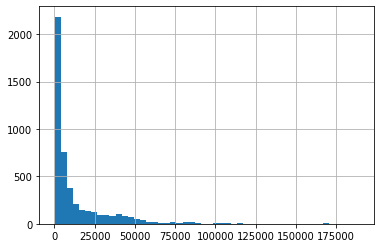

In [8]:
gdp_df['GDP'].hist(bins=50)

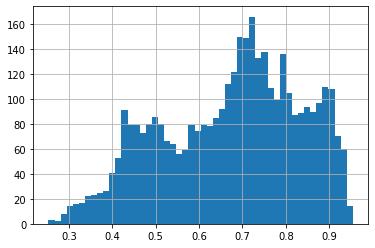

In [9]:
hdi_df['HDI'].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E74F4ED648>,
      dtype=object)

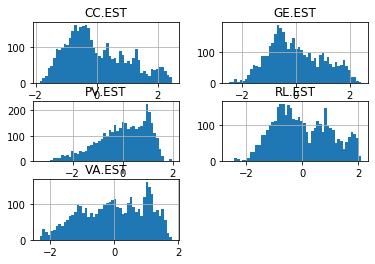

In [10]:
wgi_df[['CC.EST','GE.EST','PV.EST','RL.EST','VA.EST']].hist(bins=50)

## Handling missing values

### hdi, gdp and wgi datasets
After resolving the country name inconsistency and outlier check, we moved forward to examine outliers and missing values in the data files. We started with the analysis of the datasets to identify problematic areas, then implemented our solution to handle them. 
At this point we only focus on the hdi, gdp and wgi datasets since these datasets can be treated similarly. 
For the oecd dataset we will use other methods later. 

In [11]:
#investigating occurences of missing values in the datasets
display(hdi_df.isnull().sum())
display(gdp_df.isnull().sum())
display(wgi_df.isnull().sum())
#display a sample with missing values
display(hdi_df.iloc[hdi_df.index.get_level_values('country') == 'Eritrea'])

HDI    240
dtype: int64

GDP    542
dtype: int64

Indicator Code
CC.EST    122
GE.EST    132
PV.EST    118
RL.EST     83
RQ.EST    133
VA.EST    115
dtype: int64

HDI
country year       
Eritrea 2000    NaN
        2001    NaN
        2002    NaN
        2003    NaN
        2004    NaN
        2005  0.424
        2006  0.425
        2007  0.427
        2008  0.423
        2009  0.432
        2010  0.433
        2011  0.433
        2012  0.422
        2013  0.425
        2014  0.436
        2015  0.433
        2016  0.434
        2017  0.431
        2018  0.434

Since the hdi, gdp and wgi indicators can be treated equally and the values don't change rapidly from year to year we replace the missing data with the median of the data for the given country pairs. We selected this method because interpolation can't work properly where there are many missing values one after another. Where there weren't any data available for the given country pairs, we simply dropped the rows.

In [12]:
#it is a bit slow, please be patient!
def handle_missingMetricValues(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    #if possible try to fill missing values with interpolation
    for i in incomplete_data.index.unique(level=0):
        columns=incomplete_data[incomplete_data.index.get_level_values('country')==i].columns
        for col in columns:
            #fill missing values with mean
            median=incomplete_data.loc[incomplete_data.index.get_level_values('country') == i][col].median()
            incomplete_data.loc[(incomplete_data.index.get_level_values('country') == i) & (incomplete_data[col].isnull()), col] = median            
    #drop rows where there isn't any data, sum can't be calculated
    complete_data=incomplete_data.dropna()
    return complete_data

hdi_complete=handle_missingMetricValues(hdi_df)
gdp_complete=handle_missingMetricValues(gdp_df)
wgi_complete=handle_missingMetricValues(wgi_df)

display(hdi_complete.isnull().sum())
display(gdp_complete.isnull().sum())
display(wgi_complete.isnull().sum())

display(hdi_complete.iloc[hdi_complete.index.get_level_values('country') == 'Eritrea'])

HDI    0
dtype: int64

GDP    0
dtype: int64

Indicator Code
CC.EST    0
GE.EST    0
PV.EST    0
RL.EST    0
RQ.EST    0
VA.EST    0
dtype: int64

HDI
country year        
Eritrea 2000  0.4315
        2001  0.4315
        2002  0.4315
        2003  0.4315
        2004  0.4315
        2005  0.4240
        2006  0.4250
        2007  0.4270
        2008  0.4230
        2009  0.4320
        2010  0.4330
        2011  0.4330
        2012  0.4220
        2013  0.4250
        2014  0.4360
        2015  0.4330
        2016  0.4340
        2017  0.4310
        2018  0.4340

### Missing values in the oecd dataset
Examine the dataset and occurences of missing values

In [13]:
display(oecd_df.info())
display(oecd_df.isnull().sum())
#examining the number of people flows for given source-destination country pairs
oecd=oecd_df.reset_index()
#change year to string to avoid aggregation by groupby
oecd['year']=oecd['year'].astype(str)
#set multiindex (country-destination)
oecd=oecd.set_index(['country','destination'])
#sum the number of asylum_seekers for each country-destination pairs
agg_df=oecd.groupby(oecd.index).sum(min_count=1)
display(agg_df)
#identify the country pairs where flows of people between the countries is zero
missing_pairs=agg_df.loc[(agg_df['asylum_seekers'] == 0) |(agg_df['asylum_seekers'].isnull())]
#list the missing country pairs 
display(missing_pairs)
display(oecd.iloc[(oecd.index.get_level_values('country') == 'Albania') & (oecd.index.get_level_values('destination') == 'Chile')])

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 117180 entries, (Afghanistan, 2000) to (Zimbabwe, 2017)
Data columns (total 2 columns):
destination       117180 non-null object
asylum_seekers    79319 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.1+ MB


None

variable
destination           0
asylum_seekers    37861
dtype: int64

variable,asylum_seekers
"(Afghanistan, Australia)",15925.0
"(Afghanistan, Austria)",89800.0
"(Afghanistan, Belgium)",24826.0
"(Afghanistan, Canada)",7008.0
"(Afghanistan, Chile)",20.0
...,...
"(Zimbabwe, Sweden)",147.0
"(Zimbabwe, Switzerland)",357.0
"(Zimbabwe, Turkey)",25.0
"(Zimbabwe, United Kingdom)",41193.0


variable,asylum_seekers
"(Afghanistan, Israel)",NaN
"(Albania, Chile)",0.0
"(Albania, Israel)",NaN
"(Albania, Japan)",0.0
"(Albania, Korea)",0.0
...,...
"(Zimbabwe, Chile)",0.0
"(Zimbabwe, Estonia)",0.0
"(Zimbabwe, Iceland)",0.0
"(Zimbabwe, Latvia)",0.0


variable             year  asylum_seekers
country destination                      
Albania Chile        2000             NaN
        Chile        2001             NaN
        Chile        2002             NaN
        Chile        2003             NaN
        Chile        2004             NaN
        Chile        2005             NaN
        Chile        2006             NaN
        Chile        2007             NaN
        Chile        2008             NaN
        Chile        2009             NaN
        Chile        2010             NaN
        Chile        2011             NaN
        Chile        2012             NaN
        Chile        2013             NaN
        Chile        2014             NaN
        Chile        2015             NaN
        Chile        2016             0.0
        Chile        2017             NaN

There are a number of country pairs (e.g. Albania-Chile) where none of the years have inflows of asylum seekers between countries. Since we could not find any similar data source where there was appropiate data available for cold deck inputation. We assume that migration is not considerable between these countries and we decided to delete these rows from the final dataset. 

In [14]:
#it is a bit slow, please be patient!
def delete_missingOECDValues(incomplete_data, missing_p):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    missing_p: list of country pairs with missing data
    
    Returns
    --------
    complete_data: data frame with deleted missing values
    """
    #set country-destination multiindex on the dataset
    incomplete_data=incomplete_data.reset_index()
    incomplete_data=incomplete_data.set_index(['country','destination'])
    #delete rows where none of the years have inflows of asylum seekers between the given country pairs
    for i in incomplete_data.index.unique():
        if np.any(i==missing_p.index):
            incomplete_data.drop(i,inplace=True)
    complete_data=incomplete_data
    return complete_data
oecd_deleted=delete_missingOECDValues(oecd_df, missing_pairs)

In [15]:
#examine whether delete was successful or not
check=oecd_deleted.reset_index()
if check[(check['country']=='Albania') & (check['destination']=='Chile')].empty:
    display('Delete successful!')

'Delete successful!'

For the remaining missing values, we calculated the mean of asylum_seekers for the given country pairs and filled the holes with this value.  

In [16]:
def input_missingOECDValues(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame with inputted missing values, final dataframe that won't have missing values anymore
    """
    #set country-destination multiindex on the dataset
    incomplete_data=incomplete_data.reset_index()
    incomplete_data=incomplete_data.set_index(['country','destination'])
    #input missing values with median 
    for i in incomplete_data.index.unique():
        mean=incomplete_data.loc[(incomplete_data.index.get_level_values('country')==i[0]) & (incomplete_data.index.get_level_values('destination')==i[1])].mean()
        incomplete_data.loc[(incomplete_data.index.get_level_values('country') == i[0]) & (incomplete_data.index.get_level_values('destination')==i[1]) & (incomplete_data['asylum_seekers'].isnull()), 'asylum_seekers'] = mean.asylum_seekers
    complete_data=incomplete_data
    return complete_data
oecd_complete=input_missingOECDValues(oecd_deleted)
display(oecd_complete.isnull().sum())

variable
year              0
asylum_seekers    0
dtype: int64

In [17]:
#set back country-year as index before data merge
oecd_complete=oecd_complete.reset_index()
oecd_complete=oecd_complete.set_index(['country','year'])

In [18]:
def merge_dest(s_merged, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    s_merged: merged dataset with values for the source country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    d_merged: merged data frame that contains complete migration and country data for the source and destination countries
    """
    s_merged = s_merged.rename(columns={'destination': 'country'})
    s_merged=s_merged.set_index(['year','country'])
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    d_merged=pd.merge(merge2,s_merged,on=['year','country'])
    d_merged=d_merged.reset_index()
    d_merged = d_merged.rename(columns={'GDP': 'd_GDP',
                                             'HDI': 'd_HDI',
                                             'CC.EST': 'd_CC.EST',
                                             'GE.EST': 'd_GE.EST',
                                             'PV.EST': 'd_PV.EST',
                                             'RL.EST': 'd_RL.EST',
                                             'VA.EST': 'd_VA.EST',
                                             'RQ.EST': 'd_RQ.EST',
                                             'country': 'destination'})
    return d_merged


def merge_data(oecd_df, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    oecd_df: yearly data for foreign population inflow and asylum seeker inflow from source to destination country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    merged_data: merged data frame that contains complete migration and country data
    
    """
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    s_merged=pd.merge(merge2,oecd_df,on=['year','country'])
    s_merged=s_merged.reset_index()
    s_merged = s_merged.rename(columns={'GDP': 's_GDP',
                                             'HDI': 's_HDI',
                                             'CC.EST': 's_CC.EST',
                                             'GE.EST': 's_GE.EST',
                                             'PV.EST': 's_PV.EST',
                                             'RL.EST': 's_RL.EST',
                                             'VA.EST': 's_VA.EST',
                                             'RQ.EST': 's_RQ.EST',
                                             'country': 'source'})
    merged_data=merge_dest(s_merged,gdp_df, hdi_df, wgi_df)
    #set multiindex with year, source, destination
    merged_data=merged_data.set_index(['year','source'])
    
    return merged_data

data_merged = merge_data(oecd_complete, gdp_complete, hdi_complete, wgi_complete)
data_merged.to_csv("merged.csv")
data_merged.info()
data_merged

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72573 entries, (2000, Afghanistan) to (2017, Zimbabwe)
Data columns (total 18 columns):
destination       72573 non-null object
d_GDP             72573 non-null float64
d_HDI             72573 non-null float64
d_CC.EST          72573 non-null float64
d_GE.EST          72573 non-null float64
d_PV.EST          72573 non-null float64
d_RL.EST          72573 non-null float64
d_RQ.EST          72573 non-null float64
d_VA.EST          72573 non-null float64
s_GDP             72573 non-null float64
s_HDI             72573 non-null float64
s_CC.EST          72573 non-null float64
s_GE.EST          72573 non-null float64
s_PV.EST          72573 non-null float64
s_RL.EST          72573 non-null float64
s_RQ.EST          72573 non-null float64
s_VA.EST          72573 non-null float64
asylum_seekers    72573 non-null float64
dtypes: float64(17), object(1)
memory usage: 10.2+ MB


destination        d_GDP  d_HDI  d_CC.EST  \
year source                                                              
2000 Afghanistan               Australia  21679.24784  0.898  1.923246   
     Angola                    Australia  21679.24784  0.898  1.923246   
     Albania                   Australia  21679.24784  0.898  1.923246   
     United Arab Emirates      Australia  21679.24784  0.898  1.923246   
     Argentina                 Australia  21679.24784  0.898  1.923246   
...                                  ...          ...    ...       ...   
2017 Samoa                 United States  59927.92983  0.919  1.381242   
     Yemen                 United States  59927.92983  0.919  1.381242   
     South Africa          United States  59927.92983  0.919  1.381242   
     Zambia                United States  59927.92983  0.919  1.381242   
     Zimbabwe              United States  59927.92983  0.919  1.381242   

                           d_GE.EST  d_PV.EST  d_RL.EST  d_RQ.EST  d_VA.EST  \
year source                                                                   
2000 Afghanistan           1.810187  1.334552  1.751407  1.637249  1.471305   
     Angola                1.810187  1.334552  1.751407  1.637249  1.471305   
     Albania               1.810187  1.334552  1.751407  1.637249  1.471305   
     United Arab Emirates  1.810187  1.334552  1.751407  1.637249  1.471305   
     Argentina             1.810187  1.334552  1.751407  1.637249  1.471305   
...                             ...       ...       ...       ...       ...   
2017 Samoa                 1.554298  0.335553  1.644761  1.628115  1.049652   
     Yemen                 1.554298  0.335553  1.644761  1.628115  1.049652   
     South Africa          1.554298  0.335553  1.644761  1.628115  1.049652   
     Zambia                1.554298  0.335553  1.644761  1.628115  1.049652   
     Zimbabwe              1.554298  0.335553  1.644761  1.628115  1.049652   

                                  s_GDP  s_HDI  s_CC.EST  s_GE.EST  s_PV.EST  \
year source                                                                    
2000 Afghanistan             520.896603  0.345 -1.295380 -2.231651 -2.440187   
     Angola                  556.836318  0.394 -1.522685 -1.462310 -2.035583   
     Albania                1126.683318  0.667 -0.857256 -0.755118 -0.537979   
     United Arab Emirates  33291.419370  0.782  0.116904  0.791496  0.975109   
     Argentina              7708.100996  0.770 -0.192119  0.032177  0.099359   
...                                 ...    ...       ...       ...       ...   
2017 Samoa                  4258.486292  0.706  0.659456  0.616182  1.178530   
     Yemen                   963.494721  0.463 -1.592786 -1.915434 -2.941943   
     South Africa           6132.479841  0.704 -0.021827  0.288611 -0.277548   
     Zambia                 1534.865371  0.589 -0.542213 -0.627568  0.146180   
     Zimbabwe               1602.403507  0.553 -1.273584 -1.188722 -0.708677   

                           s_RL.EST  s_RQ.EST  s_VA.EST  asylum_seekers  
year source                                                              
2000 Afghanistan          -1.778437 -2.109626 -2.031417     1326.000000  
     Angola               -1.663307 -1.799331 -1.458065        3.000000  
     Albania              -1.008780 -0.254359 -0.285139       59.000000  
     United Arab Emirates  0.676838  0.728594 -0.516841        0.000000  
     Argentina            -0.149923  0.257245  0.418347        3.000000  
...                             ...       ...       ...             ...  
2017 Samoa                 0.868112 -0.079647  0.775607        0.882353  
     Yemen                -1.753080 -1.450046 -1.692145      120.000000  
     South Africa         -0.037856  0.233145  0.630973      157.000000  
     Zambia               -0.325046 -0.466104 -0.335299       14.764706  
     Zimbabwe             -1.377855 -1.563330 -1.196420      248.000000  

[72573 rows x 18 columns]

In [19]:
display(data_merged.isnull().sum())

destination       0
d_GDP             0
d_HDI             0
d_CC.EST          0
d_GE.EST          0
d_PV.EST          0
d_RL.EST          0
d_RQ.EST          0
d_VA.EST          0
s_GDP             0
s_HDI             0
s_CC.EST          0
s_GE.EST          0
s_PV.EST          0
s_RL.EST          0
s_RQ.EST          0
s_VA.EST          0
asylum_seekers    0
dtype: int64